In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
import math
import torch.multiprocessing as mp
from transformers import BertTokenizerFast
import pickle
import os
import json
import util
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
detokenize = tokenizer.convert_ids_to_tokens
batch_detokenize = tokenizer.batch_decode
device = 'cuda'
image_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Dùng cho ImageNet
])

In [2]:
class EncoderCNN(nn.Module):
    def __init__(self, output_size: int):
        super(EncoderCNN, self).__init__()
        self.inception_model = models.inception_v3(pretrained=True)
        #self.inception_model.fc = torch.nn.Identity()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(1000, output_size)
        for name, param in self.inception_model.named_parameters():
            if "fc.weight" in name or "fc.bias" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
    def forward(self, images: torch.Tensor):
        features = self.inception_model(images) #[1, 2048]
        if isinstance(features, tuple):  # Nếu là tuple
            features = features[0] 
        features = self.relu(features)
        features = self.dropout(features)
        features = self.fc(features)
        return features
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, vocab_size, hidden_size, input_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.vocab_size = vocab_size
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size + input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.use_hidden = False
    def forward(self, features: torch.Tensor, captions: torch.Tensor, hidden_state: tuple[torch.Tensor, torch.Tensor] = None): 
        # Constant : seq = 1
        # features : [bsz, img_sz]
        # captions : [bsz, seq]
        # hidden : [num_layers, bsz, hidden]
        embeddings = self.embed(captions) # [bsz, seq, embed]
        features = features.unsqueeze(1).expand(-1, embeddings.shape[1], -1) # [bsz, seq, embed]
        combined = torch.cat((features, embeddings), dim=2) # [bsz, seq, img_sz + embed]
        # hidden_state : [num_layers, seq, hid] * 2
        if self.use_hidden:
            output, hidden_state = self.lstm(combined, hidden_state)
        else:
            output, hidden_state = self.lstm(combined)
        # output : [bsz, seq, vocab_size]
        output = self.relu(output)
        output = self.dropout(output)
        output = self.linear(output)
        return output, hidden_state
class ImageToTextModel(nn.Module):
    def __init__(self, encoder: nn.Module, decoder: nn.Module):
        super(ImageToTextModel, self).__init__()
        self.encoder: EncoderCNN = encoder
        self.decoder: DecoderRNN = decoder
    def forward(self, images: torch.Tensor, captions: torch.Tensor):
        # Constant : SEQ_LENGTH = 46, seq = 1
        # images: [bsz, 3, raw_image_width, raw_image_height]
        # captions: [bsz, SEQ_LENGTH]
        bsz = images.shape[0]
        if self.decoder.use_hidden:
            hidden_state: tuple[torch.Tensor, torch.Tensor] = None
        features = self.encoder(images)
        # features: [bsz, img_sz]
        seq_predicted = []
        seq_predicted.append(torch.zeros((bsz, self.decoder.vocab_size), dtype=torch.float32).unsqueeze(1).to(device))
        # seq_predicted : [predict_length, seq, vocab]
        decoder_input = captions[:, 0].unsqueeze(1)
        # decoder_input : [bsz, seq]
        seq_length = captions.shape[1]
        for di in range(1, seq_length):
            if self.decoder.use_hidden:
                output_decoder, hidden_state = self.decoder(features, decoder_input, hidden_state)
            else:
                output_decoder, hidden_state = self.decoder(features, decoder_input)
            # ouput_decoder: [bsz, seq, vocab]
            # hidden_state: [num_layers, bsz, hidden_size] * 2
            decoder_input = captions[:, di].unsqueeze(1)
            # decoder_input : [bsz, seq]
            seq_predicted.append(output_decoder)
        return torch.cat(seq_predicted, dim=1)
    def predict(self, images: torch.Tensor, captions: torch.Tensor, predict_length: int):
        bsz = images.shape[0]
        hidden_state: tuple[torch.Tensor, torch.Tensor] = None
        features = self.encoder(images)
        seq_predicted = []
        seq_predicted.append(torch.zeros((bsz, self.decoder.vocab_size), dtype=torch.float32).unsqueeze(1).to(device))
        decoder_input = captions
        for _ in range(predict_length-1):
            output_decoder, hidden_state = self.decoder(features, decoder_input, hidden_state)
            seq_predicted.append(output_decoder)
            decoder_input = output_decoder.argmax(2)
        return torch.cat(seq_predicted, dim=1)


In [3]:
def plotter(train_log: list[dict[str, object]]) :
    train_loss = []
    test_loss = []
    lr = []
    accuracy = []
    bleu_1 = []
    bleu_2 = []
    bleu_3 = []
    bleu_4 = []
    for train_log_ in train_log:
        train_loss.append(train_log_.get("Train loss", 0))
        test_loss.append(train_log_.get("Test loss", 0))
        lr.append(train_log_.get("Learning rate"))
        metrics: dict[str, object] = train_log_["Metrics"]
        accuracy.append(metrics.get("accuracy"))
        bleu_1.append(metrics.get("bleu_1"))
        bleu_2.append(metrics.get("bleu_2"))
        bleu_3.append(metrics.get("bleu_4"))
        bleu_4.append(metrics.get("bleu_4"))
    figsize = (10,3)
    plt.figure(figsize=figsize)
    plt.plot(train_loss, label = "Train loss", color = "blue")
    plt.plot(test_loss, label = "Test loss", color = "red")
    plt.legend()
    plt.figure(figsize=figsize)
    plt.plot(accuracy, label= "Test accuracy", color = "blue")
    plt.legend()
    plt.figure(figsize=figsize)
    plt.plot(lr, label= "Learning rate", color = "blue")
    plt.legend()
    plt.figure(figsize=figsize)
    plt.plot(bleu_1, label= "BLEU-1", color = "blue")
    plt.legend()
    plt.figure(figsize=figsize)
    plt.plot(bleu_2, label= "BLEU-2", color = "blue")
    plt.legend()
    plt.figure(figsize=figsize)
    plt.plot(bleu_3, label= "BLEU-3", color = "blue")
    plt.legend()
    plt.figure(figsize=figsize)
    plt.plot(bleu_4, label= "BLEU-4", color = "blue")
    plt.legend()
    return test_loss, train_loss

In [4]:
TIME_STAMP = "2024-12-12_00-20-42"
CHECKPOINT_FOLDER = os.path.join("checkpoint/teset_model", TIME_STAMP)
CHECKPOINT_FOLDER = ("checkpoint/un_complete")

In [5]:

# checkpoint_path = "checkpoint/teset_model/2024-12-12_00-20-42"
# model: ImageToTextModel = util.load_model_chunks(
#     folder_path=checkpoint_path,
#     name="model"
# )
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# state_dict = util.load_state_dicts(checkpoint_path, "optimizer")['data']
# # print(state_dict)
# optimizer.load_state_dict(state_dict)

In [6]:
# with open(os.path.join(CHECKPOINT_FOLDER, "logs.json"), 'r') as file:
#     logs = json.loads(file.read())
# testloss, train_loss = plotter(logs)
# print(train_loss[9] - train_loss[4])
# print(train_loss[14] - train_loss[9])
# print(train_loss[19] - train_loss[14])
# print(train_loss[24] - train_loss[19])

In [7]:
model: ImageToTextModel = util.load_model_chunks(
    folder_path=CHECKPOINT_FOLDER,
    name="model"
)

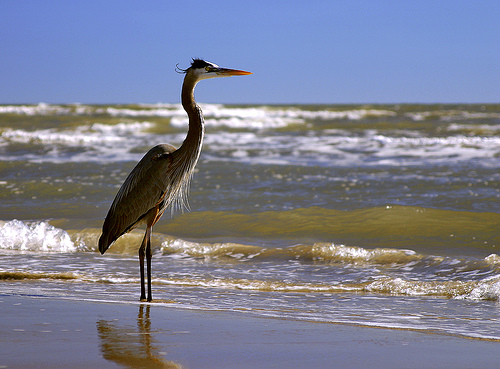

['[PAD]', 'a', 'white', 'bird', 'is', 'flying', 'over', 'the', 'water', '.', '[SEP]', '.', '[SEP]', '.', '[SEP]', '.', '[SEP]', '.', '[SEP]', '.']
['[CLS]']


In [8]:
from PIL import Image
from IPython.display import display
SEQ_LENGTH = 46
def interactive_test(
        itt: ImageToTextModel,
        image_path: str,
        text: str,
        predict_length: int
    ):
    tokens: list[int] = tokenizer.encode(text)
    tokens.pop(-1)
    # while(len(tokens) < SEQ_LENGTH):
    #     tokens = [0] + tokens
    tokens: torch.Tensor = torch.tensor(tokens)
    raw_images = Image.open(image_path).convert("RGB")
    display(raw_images)
    images = torch.Tensor(image_transforms(raw_images))
    images = images.unsqueeze(0)
    tokens = tokens.unsqueeze(0)
    itt.eval()
    images: torch.Tensor = images.to(device)
    tokens: torch.Tensor = tokens.to(device)
    output = itt.predict(images, tokens, predict_length)
    target_logits = output[:, -1, :]
    predicts = output.argmax(2)
    predicted_token = target_logits.argmax()
    # predicted_token = ""
    return predicted_token, tokens, predicts

image_ids = [
    "1386964743_9e80d96b05.jpg",
    "99679241_adc853a5c0.jpg",
    "802594049_289e3c8420.jpg",
    "110595925_f3395c8bd6.jpg",
    "667626_18933d713e.jpg"
]
image_id = image_ids[1]
image_path = f"../Flickr8k/Flicker8k_Dataset/{image_id}"
text = ""
model.to(device)
predict_token, caption, predict = interactive_test(
    model, image_path, text,
    predict_length=20
)
# print(predicts, captions)
predict_token = predict_token.item()
predict = predict[0]
caption = caption[0]
# print(predicts)
# print(captions)
# print(detokenize(predict_token))
print(detokenize(predict))
print(detokenize(caption))


# for i in range(min(len(predicts), captions.shape[0])):
#     print(detokenize(predicts[i]), detokenize(captions[i].item()))